## 深層学習の実習

### 訓練データとテストデータそれぞれの画像ファイルを読み込む

#### `image_dataset_from_directory()` で読み込む

In [1]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横224pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/train",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/test",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 20 files belonging to 2 classes.
Found 6 files belonging to 2 classes.


#### データを確認する

In [2]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

2025-08-07 13:56:49.535827: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[[ 55.71684 ,  84.00255 ,  58.71684 ],
          [ 75.686226, 106.686226,  65.66326 ],
          [ 74.29592 , 104.29592 ,  69.01532 ],
          ...,
          [137.0817  , 147.0817  , 122.08169 ],
          [151.81363 , 160.08914 , 135.95139 ],
          [161.67093 , 166.67093 , 143.67093 ]],
 
         [[ 68.563774,  98.21939 ,  64.51276 ],
          [ 78.35459 , 108.35459 ,  71.53826 ],
          [ 76.053566, 105.053566,  74.57143 ],
          ...,
          [153.72197 , 161.72197 , 137.72197 ],
          [162.4999  , 166.76526 , 143.83922 ],
          [168.33162 , 168.77805 , 147.29591 ]],
 
         [[ 83.88265 , 114.59694 ,  74.03062 ],
          [ 48.94898 ,  78.63776 ,  45.714287],
          [ 70.37754 ,  98.37754 ,  73.602036],
          ...,
          [164.41827 , 169.41827 , 146.41827 ],
          [168.49992 , 167.47188 , 146.47188 ],
          [171.46683 , 167.1556  , 146.92601 ]],
 
         ...,
 
         [[ 61.742203,  87.13503 ,  56.887627],
          [ 60.892

In [3]:
# 分類名（no／yes）をリストとして格納する
class_names = train_dataset.class_names
class_names

['no', 'yes']

2025-08-07 11:22:57.103537: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


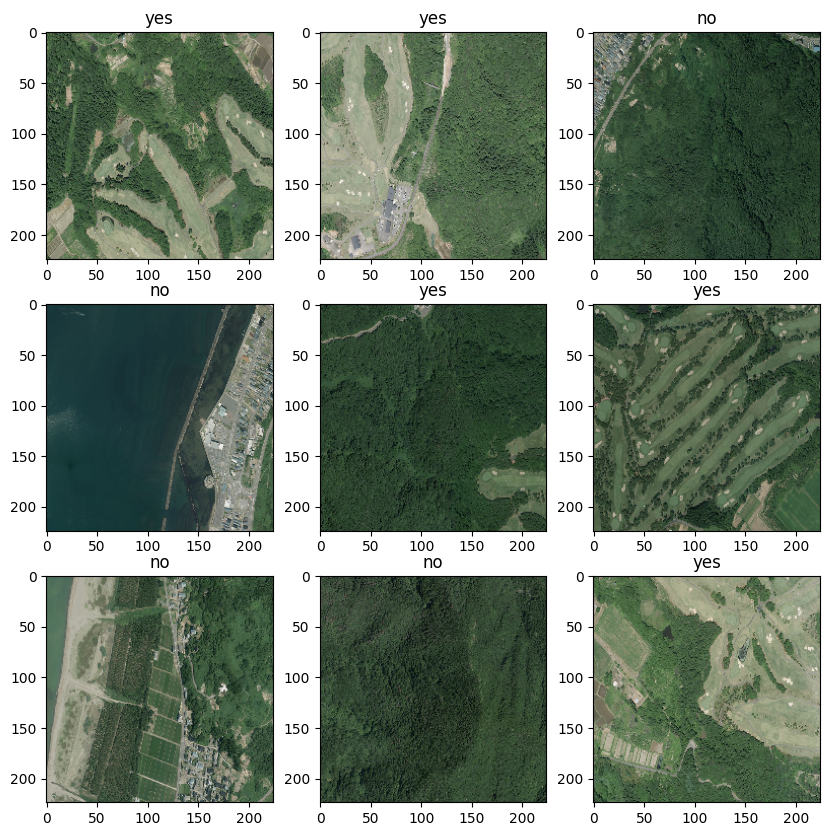

In [4]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### データの水増しを行なう

In [5]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [6]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [7]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [8]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

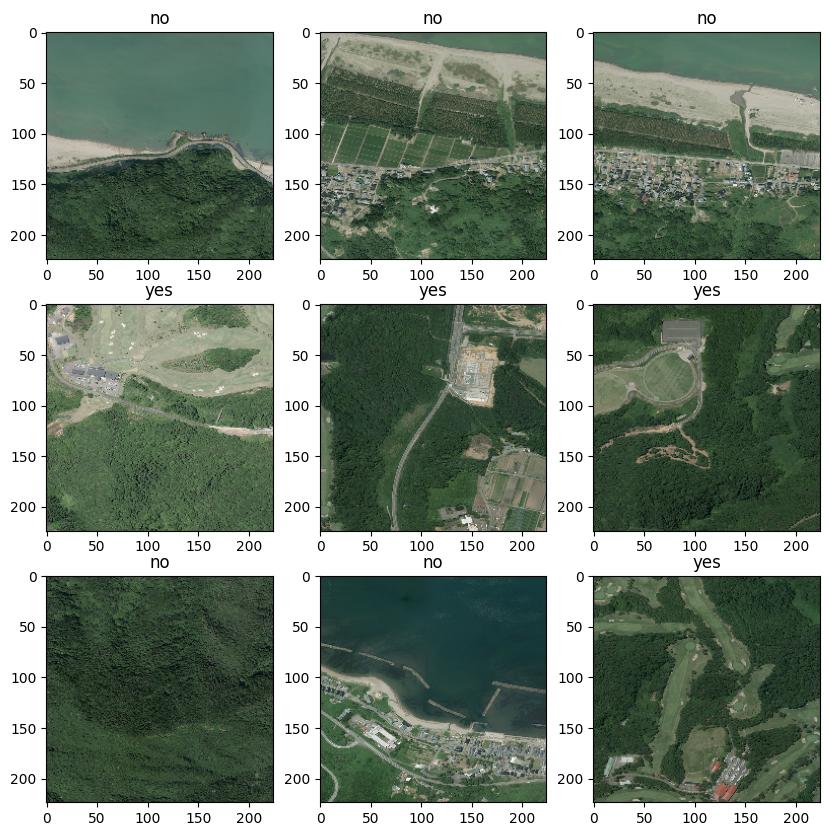

In [9]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### モデルを作って学習する

#### MobileNetV2の学習済みモデルを読み込む

In [10]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(224, 224, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#### 出力層を作成する

In [11]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#### モデルを完成させる

In [12]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [18]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [14]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.6083 - loss: 0.6855
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8667 - loss: 0.4217
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9500 - loss: 0.2786
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9917 - loss: 0.2006
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9917 - loss: 0.1543
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9917 - loss: 0.1220
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9917 - loss: 0.0996
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9917 - loss: 0.0838
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9917 - loss: 0.0716
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.0622
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 0.0549
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.0491

In [15]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


In [19]:
# 分類した結果を確認する
pred_data

array([[0.05284365],
       [0.2026304 ],
       [0.19414662],
       [0.977901  ],
       [0.6133797 ],
       [0.9869728 ]], dtype=float32)

In [20]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step - accuracy: 1.0000 - loss: 0.1701


[0.17013537883758545, 1.0]